# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [15]:
import pandas as pd
import numpy as np
import math
import json
#matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn as sns
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.pipeline import Pipeline

pd.set_option('display.max_columns', None)

In [148]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [149]:
len(portfolio)

10

In [150]:
len(profile)

17000

In [151]:
len(transcript)

306534

## Data Cleaning

### Cleaning the Portfolio data

To clean this dataframe, we would like to make categorical columns for offer_type and the channel columns.

In [152]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [153]:
portfolio.offer_type.unique()

array(['bogo', 'informational', 'discount'], dtype=object)

In [154]:
len(portfolio)

10

In [155]:
portfolio.dtypes

channels      object
difficulty     int64
duration       int64
id            object
offer_type    object
reward         int64
dtype: object

For offer type and channels, let's turn them into categorical columns.

In [156]:
df_portfolio = portfolio.copy()

In [157]:
#Source: https://stackoverflow.com/questions/37292872/how-can-i-one-hot-encode-in-python

#Get one hot encoding of column 'offer_type'
one_hot = pd.get_dummies(df_portfolio['offer_type'])

#Drop column offer_type
df_portfolio = df_portfolio.drop('offer_type', axis=1)

#Join the encoded data frame
df_portfolio = df_portfolio.join(one_hot)

Since the channel column is a series of lists, we have to handle this a bit differently in order to make categorical columns.

In [158]:
#Source: https://izziswift.com/how-to-one-hot-encode-from-a-pandas-column-containing-a-list/

df_portfolio = df_portfolio.drop('channels', 1).join(df_portfolio.channels.str.join('|').str.get_dummies())

In [159]:
df_portfolio.isnull().any()

difficulty       False
duration         False
id               False
reward           False
bogo             False
discount         False
informational    False
email            False
mobile           False
social           False
web              False
dtype: bool

In [160]:
df_portfolio = df_portfolio.rename(columns={'id':'offer_id'})

In [161]:
df_portfolio.head()

,difficulty,duration,offer_id,reward,bogo,discount,informational,email,mobile,social,web
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,10,1,0,0,1,1,1,0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,10,1,0,0,1,1,1,1
2,0,4,3f207df678b143eea3cee63160fa8bed,0,0,0,1,1,1,0,1
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,1,0,0,1,1,0,1
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,0,1,0,1,0,0,1


### Cleaning the Profile data

For the profile dataframe, it would be best to change the became_member_on column to a proper datetime format, and to replace None the none values in the whole dataframe.

Also, let's create age groups and income classes for the age and income columns.

In [162]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [163]:
profile.dtypes

age                   int64
became_member_on      int64
gender               object
id                   object
income              float64
dtype: object

In [164]:
profile.isnull().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

In [165]:
#profile[profile['age'] == 118].count()

In [166]:
len(profile)

17000

In [167]:
profile_df = profile.copy()

In [168]:
profile_df.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [169]:
#https://stackoverflow.com/questions/49382207/how-to-map-numeric-data-into-categories-bins-in-pandas-dataframe
bins = [17, 30, 55, 75, np.inf]
names = ['Young_Adult', 'Adult', 'Senior', 'Old']

In [170]:
profile_df['age_class'] = pd.cut(profile_df['age'], bins, labels=names)

In [171]:
bins = [29000.00, 49000.00, 79000.00, 89000.00, np.inf]
names = ['Lower', 'Average', 'Above_Avg', 'Upper']

In [172]:
profile_df['income_class'] = pd.cut(profile_df['income'], bins, labels=names)

In [173]:
profile_df.head()

,age,became_member_on,gender,id,income,age_class,income_class
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN,Old,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0,Adult,Upper
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN,Old,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,Senior,Upper
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN,Old,NaN


Let's change the date formatting. Then create a year-month coloumn from the *became_member_on* column

In [174]:
profile_df[["became_member_on"]] = profile_df[["became_member_on"]].apply(pd.to_datetime, format = '%Y%m%d')

In [175]:
profile_df.head()

,age,became_member_on,gender,id,income,age_class,income_class
0,118,2017-02-12,None,68be06ca386d4c31939f3a4f0e3dd783,NaN,Old,NaN
1,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0,Adult,Upper
2,118,2018-07-12,None,38fe809add3b4fcf9315a9694bb96ff5,NaN,Old,NaN
3,75,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,Senior,Upper
4,118,2017-08-04,None,a03223e636434f42ac4c3df47e8bac43,NaN,Old,NaN


In [176]:
#new_member_on = profile_df['became_member_on'].apply(to_datetime)

In [177]:
#profile_df = profile_df.drop(['became_member_on'], axis=1)
#profile_df['became_member_on'] = new_member_on

In [178]:
profile_df["member_year"] = profile_df['became_member_on'].dt.strftime("%Y")
profile_df["member_month"] = profile_df['became_member_on'].dt.strftime("%m")
profile_df["member_year_month"] = profile_df['became_member_on'].dt.strftime("%Y-%m")

In [179]:
profile_df = profile_df[profile_df['income'].notnull()]

In [180]:
profile_df.head()

,age,became_member_on,gender,id,income,age_class,income_class,member_year,member_month,member_year_month
1,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0,Adult,Upper,2017,07,2017-07
3,75,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,Senior,Upper,2017,05,2017-05
5,68,2018-04-26,M,e2127556f4f64592b11af22de27a7932,70000.0,Senior,Average,2018,04,2018-04
8,65,2018-02-09,M,389bc3fa690240e798340f5a15918d5c,53000.0,Senior,Average,2018,02,2018-02
12,58,2017-11-11,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,Senior,Average,2017,11,2017-11


In [181]:
profile_df.gender.value_counts()

M    8484
F    6129
O     212
Name: gender, dtype: int64

In [182]:
len(profile_df)

14825

### Cleaning the Transcript Data

For the transcript data, we will remove customer ids that are not present in the profile dataframe. We will also convert the time column from hours to days. This will be useful later when we are trying to decide whether or not an offer is successful or not.

We will then split the data into two dataframes: offers and transactions.

In [183]:
transcript_df = transcript.copy()

In [184]:
len(transcript_df)

306534

In [185]:
transcript_df = transcript_df.rename(columns = {'person': 'id'})

#### Remove customer ids in the transcript that are not present in the profile

In [186]:
common_ids = transcript_df['id'].isin(profile_df['id'])
transcript_df = transcript_df[common_ids]

In [187]:
percent_removed = 100 * (1 - common_ids.sum() / common_ids.shape[0])
print("Percentage of transactions removed: %.2f %%" % percent_removed)

Percentage of transactions removed: 11.02 %


In [188]:
#convert hours to days in the time column
my_int = 24.0
transcript_df['time'] = [x / my_int for x in transcript_df['time']]

In [189]:
#transcript['time']

In [190]:
len(transcript_df)

272762

#### Split into offer and transaction data

In [191]:
offers = transcript_df[transcript_df['event']  != 'transaction']

transaction = transcript_df[transcript_df['event']  == 'transaction']

In [192]:
offers['offer_id'] = [[*i.values()][0] if [*i.keys()][0] in ['offer id',
                                        'value'] else None
                                        for i in offers.value]

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [193]:
transaction['amount_spent'] = [[*i.values()][0] if [*i.keys()][0] in ['amount',
                                        'value'] else None
                                        for i in transaction.value]

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [194]:
offers.head()

,event,id,time,value,offer_id
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0.0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9
2,offer received,e2127556f4f64592b11af22de27a7932,0.0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},2906b810c7d4411798c6938adc9daaa5
5,offer received,389bc3fa690240e798340f5a15918d5c,0.0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},f19421c1d4aa40978ebb69ca19b0e20d
7,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0.0,{'offer id': '3f207df678b143eea3cee63160fa8bed'},3f207df678b143eea3cee63160fa8bed
8,offer received,aa4862eba776480b8bb9c68455b8c2e1,0.0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7


In [195]:
len(offers)

148805

In [196]:
transaction.head()

,event,id,time,value,amount_spent
12654,transaction,02c083884c7d45b39cc68e1314fec56c,0.0,{'amount': 0.8300000000000001},0.83
12657,transaction,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0.0,{'amount': 34.56},34.56
12659,transaction,54890f68699049c2a04d415abc25e717,0.0,{'amount': 13.23},13.23
12670,transaction,b2f1cd155b864803ad8334cdf13c4bd2,0.0,{'amount': 19.51},19.51
12671,transaction,fe97aa22dd3e48c8b143116a8403dd52,0.0,{'amount': 18.97},18.97


In [197]:
#transaction.time.value_counts()

In [198]:
len(transaction)

123957

### Portfolio Analysis

In [199]:
df_portfolio.head()

,difficulty,duration,offer_id,reward,bogo,discount,informational,email,mobile,social,web
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,10,1,0,0,1,1,1,0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,10,1,0,0,1,1,1,1
2,0,4,3f207df678b143eea3cee63160fa8bed,0,0,0,1,1,1,0,1
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,1,0,0,1,1,0,1
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,0,1,0,1,0,0,1


In [200]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


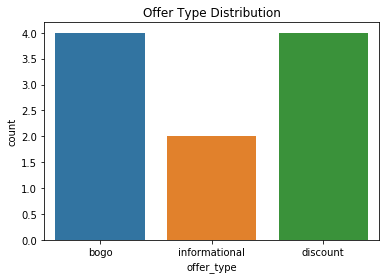

In [201]:
ax = sns.countplot(x=portfolio['offer_type'], data=portfolio)
ax.set_title('Offer Type Distribution');

We see that the most present offer types are BOGO and discounts.

### Profile Analysis

In [202]:
profile_df.head()

,age,became_member_on,gender,id,income,age_class,income_class,member_year,member_month,member_year_month
1,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0,Adult,Upper,2017,07,2017-07
3,75,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,Senior,Upper,2017,05,2017-05
5,68,2018-04-26,M,e2127556f4f64592b11af22de27a7932,70000.0,Senior,Average,2018,04,2018-04
8,65,2018-02-09,M,389bc3fa690240e798340f5a15918d5c,53000.0,Senior,Average,2018,02,2018-02
12,58,2017-11-11,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,Senior,Average,2017,11,2017-11


In [203]:
profile_df.dtypes

age                           int64
became_member_on     datetime64[ns]
gender                       object
id                           object
income                      float64
age_class                  category
income_class               category
member_year                  object
member_month                 object
member_year_month            object
dtype: object

In [204]:
profile_df.describe()

,age,income
count,14825.000000,14825.000000
mean,54.393524,65404.991568
std,17.383705,21598.299410
min,18.000000,30000.000000
25%,42.000000,49000.000000
50%,55.000000,64000.000000
75%,66.000000,80000.000000
max,101.000000,120000.000000


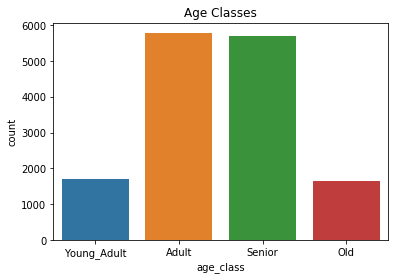

In [205]:
ax = sns.countplot(x=profile_df['age_class'], data=profile_df)
ax.set_title('Age Classes');

When comparing the count of age groups, the most common customers' age fall under the Adult and Senior groups.

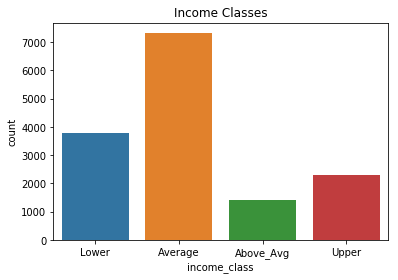

In [206]:
ax = sns.countplot(x=profile_df['income_class'], data=profile_df)
ax.set_title('Income Classes');

In [207]:
bins = [29000.00, 49000.00, 79000.00, 89000.00, np.inf]
names = ['Lower', 'Average', 'Above_Avg', 'Upper']

As for the income classes, we see people who have an average income shop the most at Starbucks

Remember, the ranges for each class are:

Lower: 29000 to 49000

Average: 49000 to 79000

Above_Avg: 79000 to 89000

Upper: Above 89000

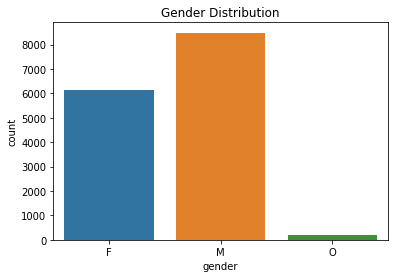

In [208]:
ax = sns.countplot(x=profile_df['gender'], data=profile_df)
ax.set_title('Gender Distribution');

While, the gender that shops the most here is Male.

What months throughout the year do people typically become a member?

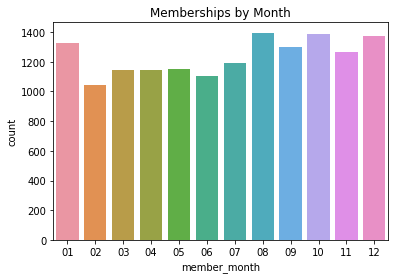

In [209]:
ax = sns.countplot(x=profile_df['member_month'], data=profile_df)
ax.set_title('Memberships by Month');

Looks like January, August, October, and December top out the rest of the year. But from February to July there is an ever slight increase in memberships before it makes a larger jump in August huge.

What year was the most successful in terms of new members?

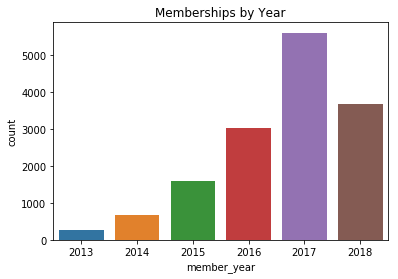

In [210]:
ax = sns.countplot(x=profile_df['member_year'], data=profile_df)
ax.set_title('Memberships by Year');

We clearly see that in 2017 there was the most amount of memberships.

### Transcript (Offer Data and Transaction) Analysis

#### Offers

In [211]:
offers.head()

,event,id,time,value,offer_id
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0.0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9
2,offer received,e2127556f4f64592b11af22de27a7932,0.0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},2906b810c7d4411798c6938adc9daaa5
5,offer received,389bc3fa690240e798340f5a15918d5c,0.0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},f19421c1d4aa40978ebb69ca19b0e20d
7,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0.0,{'offer id': '3f207df678b143eea3cee63160fa8bed'},3f207df678b143eea3cee63160fa8bed
8,offer received,aa4862eba776480b8bb9c68455b8c2e1,0.0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7


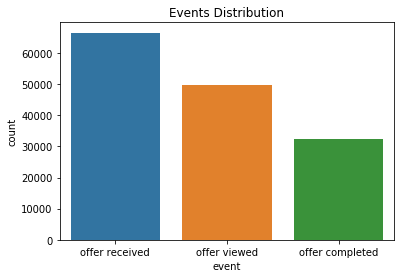

In [212]:
ax = sns.countplot(x=offers['event'], data=profile_df)
ax.set_title('Events Distribution');

The offer event that appears the most is offer received.

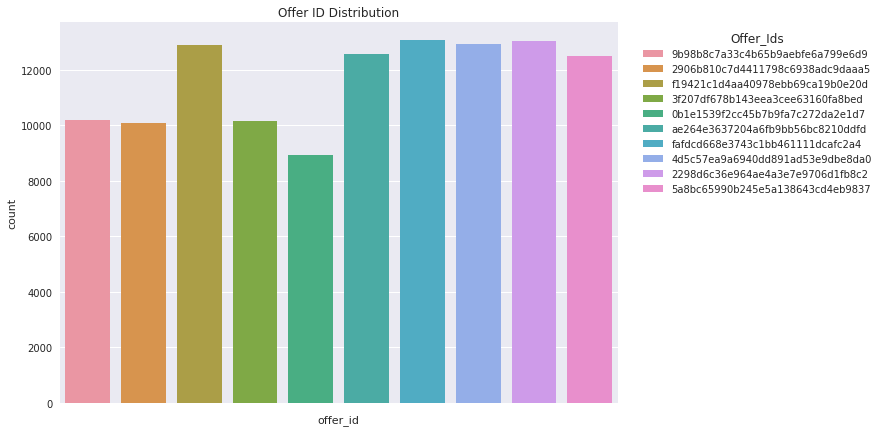

In [213]:
sns.set(rc={"figure.figsize":(10, 7)})
ax = sns.countplot(x=offers['offer_id'], hue=offers['offer_id'], data=offers, dodge=False)
ax.set_title('Offer ID Distribution')
#plt.legend(handles=patches, loc="upper left") 

ax.legend(bbox_to_anchor = (1.03, 1), title='Offer_Ids' );
#ax.set_xticklabels(ax.get_xticklabels(), rotation=75, horizontalalignment='right');
ax.set(xticklabels=[]);

#### Transactions

In [214]:
transaction.head()

,event,id,time,value,amount_spent
12654,transaction,02c083884c7d45b39cc68e1314fec56c,0.0,{'amount': 0.8300000000000001},0.83
12657,transaction,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0.0,{'amount': 34.56},34.56
12659,transaction,54890f68699049c2a04d415abc25e717,0.0,{'amount': 13.23},13.23
12670,transaction,b2f1cd155b864803ad8334cdf13c4bd2,0.0,{'amount': 19.51},19.51
12671,transaction,fe97aa22dd3e48c8b143116a8403dd52,0.0,{'amount': 18.97},18.97


In [215]:
profile_df.head()

,age,became_member_on,gender,id,income,age_class,income_class,member_year,member_month,member_year_month
1,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0,Adult,Upper,2017,07,2017-07
3,75,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,Senior,Upper,2017,05,2017-05
5,68,2018-04-26,M,e2127556f4f64592b11af22de27a7932,70000.0,Senior,Average,2018,04,2018-04
8,65,2018-02-09,M,389bc3fa690240e798340f5a15918d5c,53000.0,Senior,Average,2018,02,2018-02
12,58,2017-11-11,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,Senior,Average,2017,11,2017-11


In [216]:
len(profile)

17000

In [217]:
len(transaction)

123957

We will combine transactions with the profile_df on id in order to get the customer information for each transaction.

In [218]:
profile_transactions = pd.merge(transaction, profile_df, on='id', how='left')

In [219]:
len(profile_transactions)

123957

In [220]:
profile_transactions.head()

,event,id,time,value,amount_spent,age,became_member_on,gender,income,age_class,income_class,member_year,member_month,member_year_month
0,transaction,02c083884c7d45b39cc68e1314fec56c,0.0,{'amount': 0.8300000000000001},0.83,20,2016-07-11,F,30000.0,Young_Adult,Lower,2016,07,2016-07
1,transaction,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0.0,{'amount': 34.56},34.56,42,2016-01-17,M,96000.0,Adult,Upper,2016,01,2016-01
2,transaction,54890f68699049c2a04d415abc25e717,0.0,{'amount': 13.23},13.23,36,2017-12-28,M,56000.0,Adult,Average,2017,12,2017-12
3,transaction,b2f1cd155b864803ad8334cdf13c4bd2,0.0,{'amount': 19.51},19.51,55,2017-10-16,F,94000.0,Adult,Upper,2017,10,2017-10
4,transaction,fe97aa22dd3e48c8b143116a8403dd52,0.0,{'amount': 18.97},18.97,39,2017-12-17,F,67000.0,Adult,Average,2017,12,2017-12


In [221]:
profile_transactions.isnull().values.any()

False

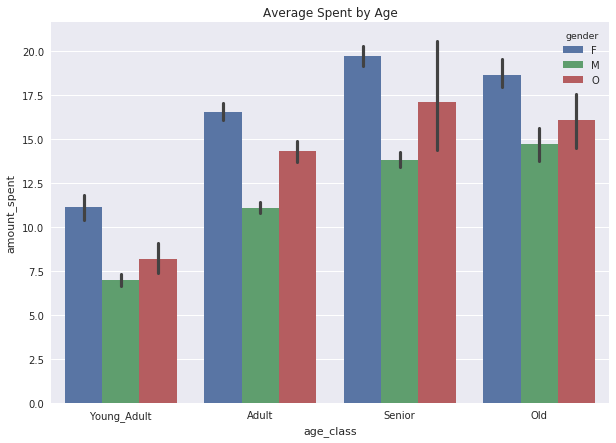

In [222]:
ax = sns.barplot(x="age_class", y="amount_spent", hue="gender", data=profile_transactions);
ax.set_title('Average Spent by Age');
#amount spent is plotted by the mean. This is the default for seaborn

Here is the average amount spent by gender for each age group. Looks like male seniors spend the most.

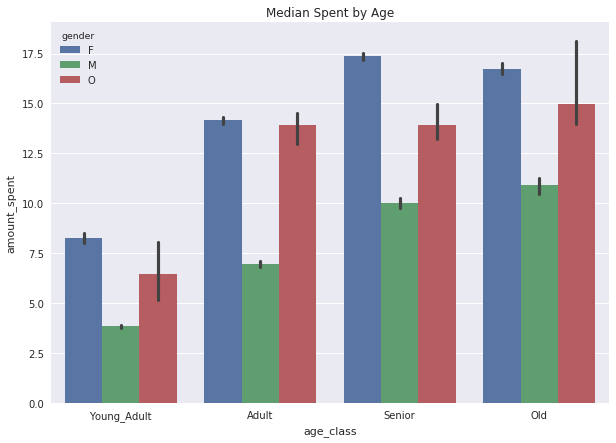

In [223]:
#median spent
ax = sns.barplot(x="age_class", y="amount_spent", hue="gender", 
                 data=profile_transactions, estimator = np.median);
ax.set_title('Median Spent by Age');

As for the median spent, male seniors are still the highest, with older males coming in second.

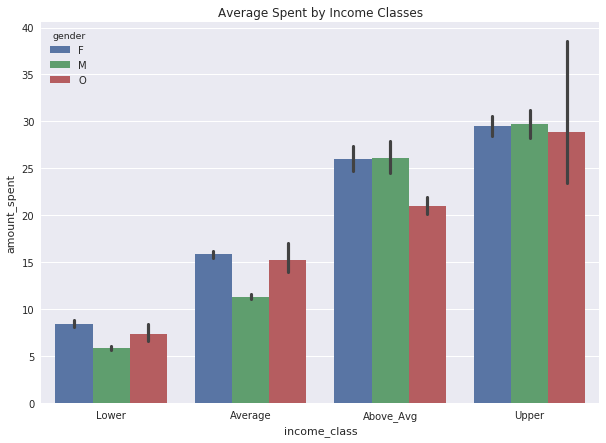

In [224]:
ax = sns.barplot(x="income_class", y="amount_spent", hue="gender", data=profile_transactions);
ax.set_title('Average Spent by Income Classes');

When we look at the income classes, the amount spent is much higher for those in the upper income class.

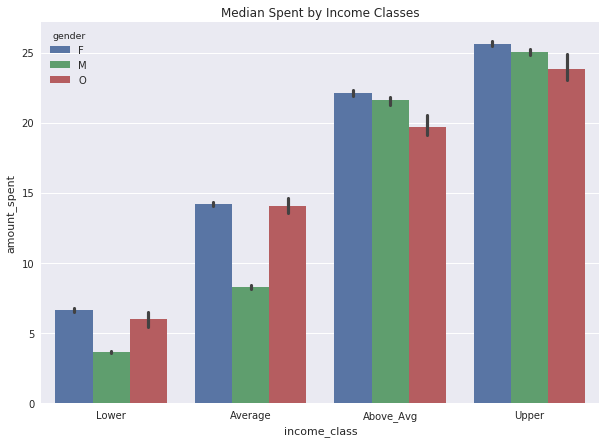

In [225]:
ax = sns.barplot(x="income_class", y="amount_spent", hue="gender",
                 data=profile_transactions, estimator=np.median);
ax.set_title('Median Spent by Income Classes');

The same can be said about the median amount spent. Those in the upper income class spend the most.

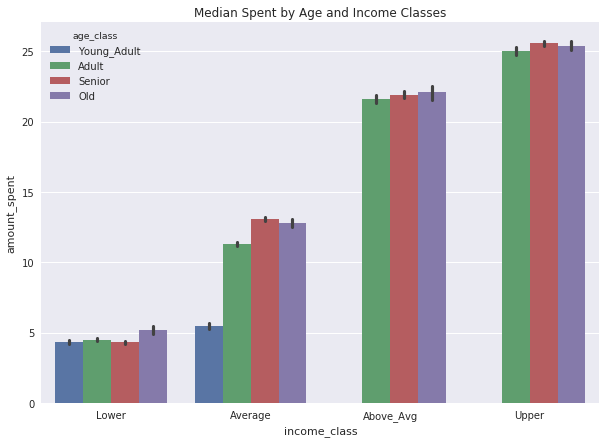

In [227]:
ax = sns.barplot(x="income_class", y="amount_spent", hue="age_class", 
                 data=profile_transactions, estimator = np.median);
ax.set_title('Median Spent by Age and Income Classes');

When we look at age and income classes, once again the upper class contains those that spend the most as the median values.

Now we want to look at the cutomer information for all of the offers in the offers dataframe.

In [228]:
profile_offers = pd.merge(offers, profile_df, on='id', how='left')

In [229]:
profile_offers.head()

,event,id,time,value,offer_id,age,became_member_on,gender,income,age_class,income_class,member_year,member_month,member_year_month
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0.0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9,75,2017-05-09,F,100000.0,Senior,Upper,2017,05,2017-05
1,offer received,e2127556f4f64592b11af22de27a7932,0.0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},2906b810c7d4411798c6938adc9daaa5,68,2018-04-26,M,70000.0,Senior,Average,2018,04,2018-04
2,offer received,389bc3fa690240e798340f5a15918d5c,0.0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},f19421c1d4aa40978ebb69ca19b0e20d,65,2018-02-09,M,53000.0,Senior,Average,2018,02,2018-02
3,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0.0,{'offer id': '3f207df678b143eea3cee63160fa8bed'},3f207df678b143eea3cee63160fa8bed,58,2017-11-11,M,51000.0,Senior,Average,2017,11,2017-11
4,offer received,aa4862eba776480b8bb9c68455b8c2e1,0.0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7,61,2017-09-11,F,57000.0,Senior,Average,2017,09,2017-09


In [230]:
profile_offers.event.value_counts()

offer received     66501
offer viewed       49860
offer completed    32444
Name: event, dtype: int64

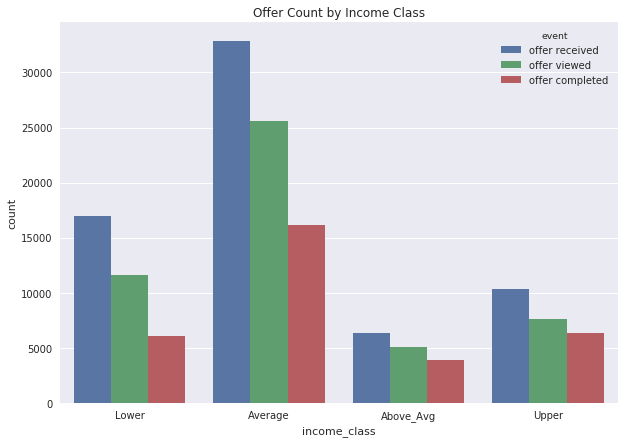

In [231]:
ax = sns.countplot(x="income_class", hue="event", 
                 data=profile_offers);
ax.set_title('Offer Count by Income Class');

For income class, those who make an average amount recieve the most offers.

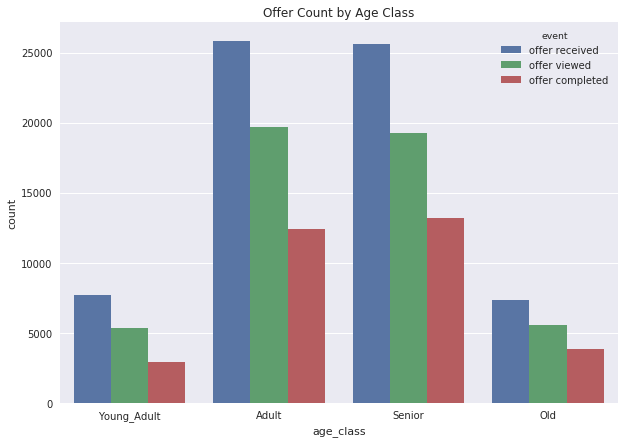

In [232]:
ax = sns.countplot(x="age_class", hue="event", 
                 data=profile_offers);
ax.set_title('Offer Count by Age Class');

However, for age class, it looks like Adults and Seniors get the most of all 3 offer types.

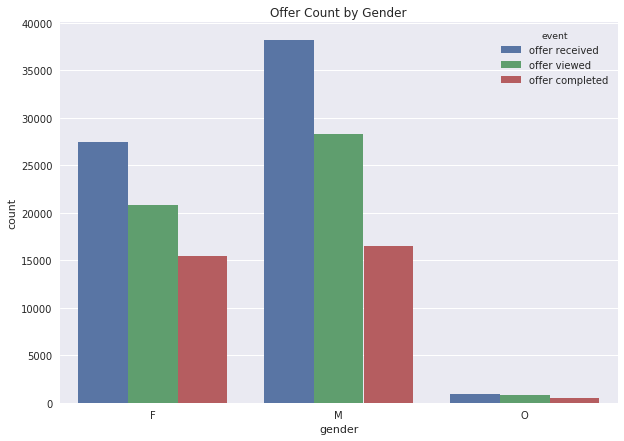

In [233]:
ax = sns.countplot(x="gender", hue="event", 
                 data=profile_offers);
ax.set_title('Offer Count by Gender');

When we look at gender, we see that males ge the most of the 3 offer types.

### Combining the 3 Data Sets

In [117]:
unique_ids = offers['id'].unique()

In [92]:
type(unique_ids)

numpy.ndarray

In [93]:
len(unique_ids)

14820

In [94]:
unique_ids[1]

'e2127556f4f64592b11af22de27a7932'

Now this next cell is a bit complex, so here is a short summary of what is going on here.

For every unique customer id, we are going to get the offers and transactions associated with that id and all of the information that goes along with those that are found in the profile and portfolio dataframes.

Once we have that information for that one unique customer id, we will go through each row of information to see whether or not the offer was completed within the time window where the offer is valid. If this is true, then we can say the offer was successful. We do this for all offers, for all unique customer ids.

In [153]:
cleaningdata = []

#For every index in the list of unique_ids
for i in range(len(unique_ids)):
    
    #We set the current_id equal to the the id number in profile_df on the ith unique_id value
    current_id = profile_df[profile_df['id'] == unique_ids[i]]

    # Now we get all of the offer data from the current customer
    selected_offers = offers['id'] == unique_ids[i]
    current_id_offers = offers[selected_offers]
    
    #We drop the id column to avoid repeated information
    current_id_offers = current_id_offers.drop(columns='id').reset_index(drop=True)

    
    # Here we get the transactions from the current customer
    pick_transactions = transaction['id'] == unique_ids[i]
    current_id_transaction = transaction[pick_transactions]
    
    #Once again, we drop the id column to avoid repeated information
    current_id_transaction = current_id_transaction.drop(columns='id').reset_index(drop=True)

    
    #Now we make dataframes based off of the event types in current_id_offers
    offer_received = current_id_offers[current_id_offers['event'] == 'offer received']
    offer_viewed = current_id_offers[current_id_offers['event'] == 'offer viewed']
    offer_completed = current_id_offers[current_id_offers['event'] == 'offer completed']
    
    #Get the 0th index of shape for offer_received
    offers_shape = offer_received.shape[0]
    
    #We want to see if the offer was successful. So...
    #For every index in offer_received.shape[0],
    for j in range(offers_shape):

        # Get current_offer_id
        current_offer_id = offer_received.iloc[j]['offer_id']

        # Get the info of the current offer from the df_portfolio of the current_offer_id
        cur_offer_portfolio = df_portfolio[df_portfolio['offer_id'] == current_offer_id]
        
        # Get the duration of the offer
        duration = cur_offer_portfolio['duration'].values[0]

        # An offer is valid from when the time begins up to how long the duration is.
        cur_start_time = offer_received.iloc[j]['time']
        cur_end_time = offer_received.iloc[j]['time'] + duration

        # Now we want the transactions, completed offers, and viewed offers that
        # are within the valid time window.
        
        #Time window for transactions
        data_transactions = []
        
        for k in current_id_transaction['time']:
            if (k >= cur_start_time and k <= cur_end_time):
                data_transactions.append(True)
            else:
                data_transactions.append(False)
                
        pick_transactions = pd.Series(data_transactions)

        
        #Time window for completed offers
        data_offer_completed = []
        
        for k in offer_completed['time']:
            if (k >= cur_start_time and k <= cur_end_time):
                data_offer_completed.append(True)
            else:
                data_offer_completed.append(False)    
                
        offer_completed_series = pd.Series(data_offer_completed)
        
        
        #Time window for viewed offers
        data_offer_viewed = []
        
        for k in offer_viewed['time']:
            if (k >= cur_start_time and k <= cur_end_time):
                data_offer_viewed.append(True)
            else:
                data_offer_viewed.append(False)
        
        offer_viewed_series = pd.Series(data_offer_viewed)

        
        # Now we check if the offer was a success
        if (offer_viewed_series.sum () > 0 and offer_completed_series.sum() > 0):
            cur_offer_successful = 1 #Successful
        else:
            cur_offer_successful = 0 #Not Successful

            
        # Now we make a dict with offersuccessful and time. 
        # We use this to update our cleaningdata list index by index
        row_dict = {'time': cur_start_time, 'offer_successful': cur_offer_successful}
        
        #Select all rows and cols of cur_offer_portfolio 
        x = cur_offer_portfolio.iloc[0,1:].to_dict()
        #& turn into a dictionary to update row_dct with x
        row_dict.update(x)

        #Select all rows and cols of current_id 
        y = current_id.iloc[0,1:].to_dict()
        #& turn into a dictionary to update row_dct with y
        row_dict.update(y)

        # We append row_dict to cleaningdata that contains the current customer's info
        cleaningdata.append(row_dict)

    cleaningdata


In [75]:
#len(cleaningdata)

In [76]:
#import multiprocessing as mp
#print(mp.cpu_count())

In [1]:
#cleaningdata

In [155]:
cleaned_data = pd.DataFrame(cleaningdata)

In [156]:
cleaned_data.to_csv('cleaned_data.csv', index=False)

## Load the merged_data

In [8]:
merged_data = pd.read_csv('cleaned_data.csv')

In [235]:
merged_data.head()

,age_class,became_member_on,bogo,discount,duration,email,gender,id,income,income_class,informational,member_month,member_year,member_year_month,mobile,offer_id,offer_successful,reward,social,time,web
0,Senior,2017-05-09,1,0,7,1,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,Upper,0,5,2017,2017-05,1,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,5,0,0.0,1
1,Senior,2017-05-09,0,0,3,1,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,Upper,1,5,2017,2017-05,1,5a8bc65990b245e5a138643cd4eb9837,0,0,1,7.0,0
2,Senior,2017-05-09,1,0,7,1,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,Upper,0,5,2017,2017-05,1,ae264e3637204a6fb9bb56bc8210ddfd,1,10,1,17.0,0
3,Senior,2017-05-09,1,0,5,1,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,Upper,0,5,2017,2017-05,1,f19421c1d4aa40978ebb69ca19b0e20d,1,5,1,21.0,1
4,Senior,2018-04-26,0,1,7,1,M,e2127556f4f64592b11af22de27a7932,70000.0,Average,0,4,2018,2018-04,1,2906b810c7d4411798c6938adc9daaa5,0,2,0,0.0,1


In [236]:
merged_data.offer_successful.value_counts()

0    35136
1    31365
Name: offer_successful, dtype: int64

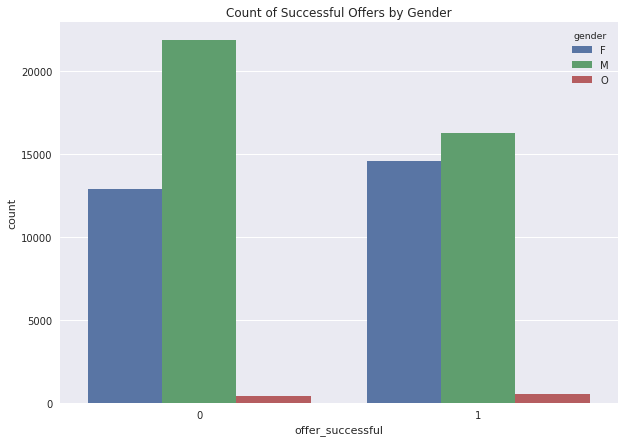

In [237]:
ax = sns.countplot(x="offer_successful", hue="gender", 
                 data=merged_data);
ax.set_title('Count of Successful Offers by Gender');

When looking at gender, we see that offers were mostly unsuccessful for males, but more successful for females.

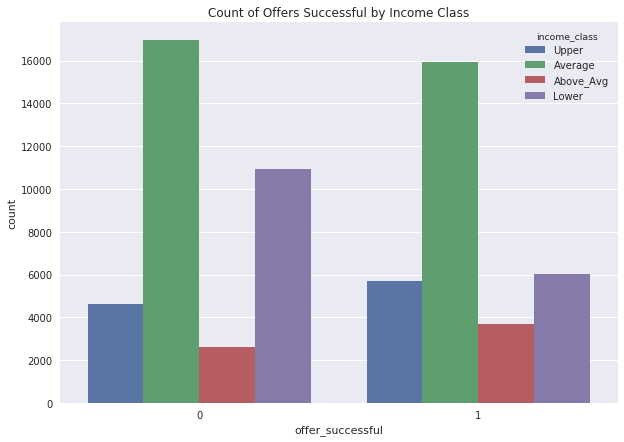

In [238]:
ax = sns.countplot(x="offer_successful", hue="income_class", 
                 data=merged_data);
ax.set_title('Count of Offers Successful by Income Class');

For income classes, we see that offers are more successful for upper and above average customers, and more unsuccessful for average and lower income customers.

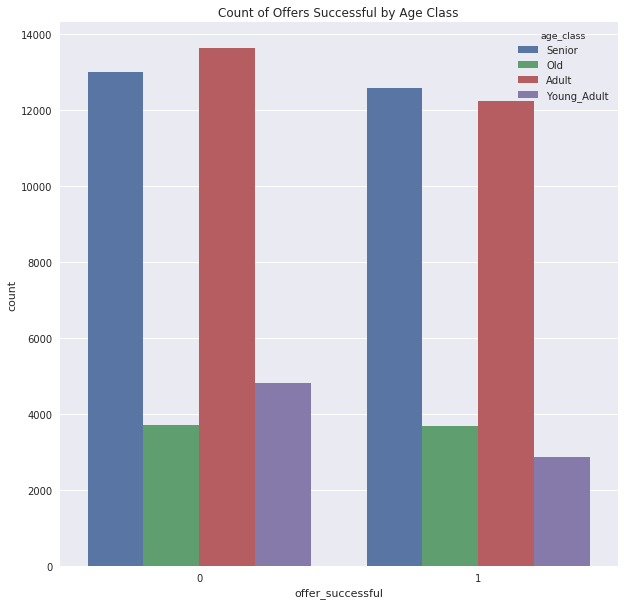

In [239]:
sns.set(rc={"figure.figsize":(10, 10)})
ax = sns.countplot(x="offer_successful", hue="age_class", 
                 data=merged_data);
ax.set_title('Count of Offers Successful by Age Class');

For all age groups, it seems as if offers are unsuccessful.

Let's take a look of the types of successful offers, like BOGO, Discounts, and Information.

In [241]:
merged_success = merged_data[merged_data['offer_successful'] == 1]

In [242]:
len(merged_success)

31365

In [243]:
merged_success_bogo = merged_success[merged_success['bogo'] == 1]

#### Bogo Success Groups

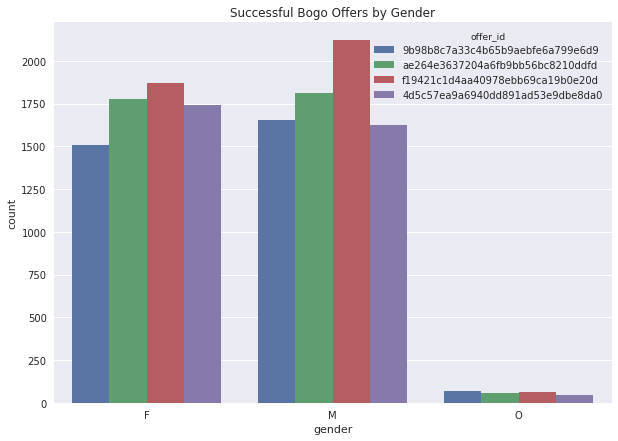

In [244]:
sns.set(rc={"figure.figsize":(10, 7)})
ax = sns.countplot(x="gender", hue="offer_id", 
                 data=merged_success_bogo);
ax.set_title('Successful Bogo Offers by Gender');

The offer_id in burgundy looks to be the most successful for male and females.

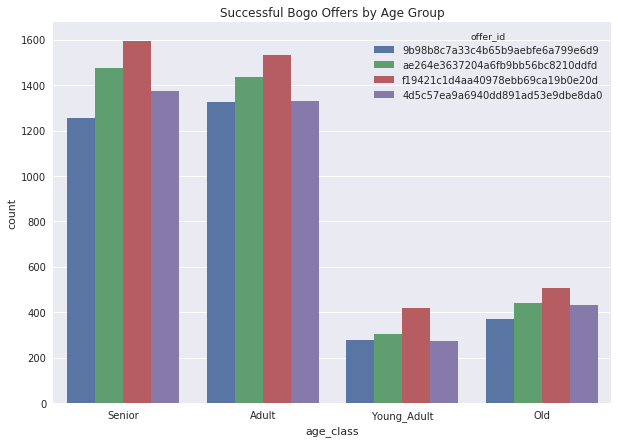

In [253]:
ax = sns.countplot(x="age_class", hue="offer_id", 
                 data=merged_success_bogo);
ax.set_title('Successful Bogo Offers by Age Group');

Once again, the bogo offer in burgundy is the most successful for all 4 age groups.

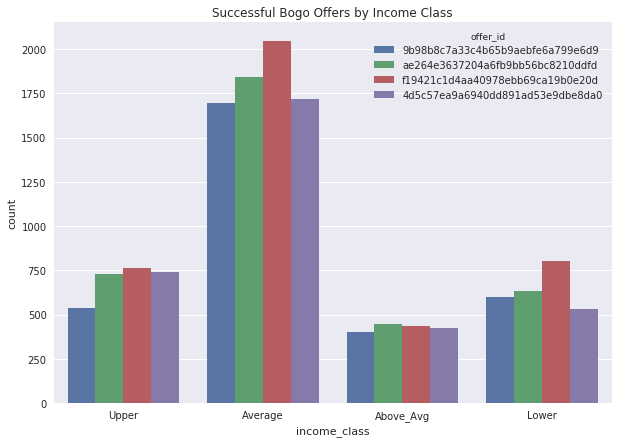

In [246]:
ax = sns.countplot(x="income_class", hue="offer_id", 
                 data=merged_success_bogo);
ax.set_title('Successful Bogo Offers by Income Class');

The same can be said for the upper, average, and lower income classes. However, for above average income customers, the 4 offers seem very close together.

#### Informational Success Groups

In [247]:
merged_success_info = merged_success[merged_success['informational'] == 1]

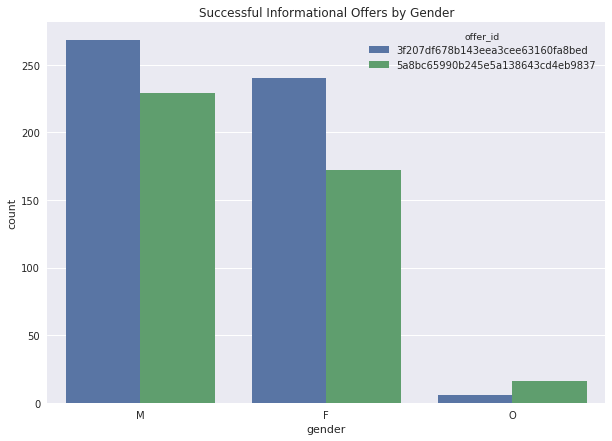

In [249]:
ax = sns.countplot(x="gender", hue="offer_id", 
                 data=merged_success_info);
ax.set_title('Successful Informational Offers by Gender');

For these two informational offers, it looks like they are most successful with male customers.

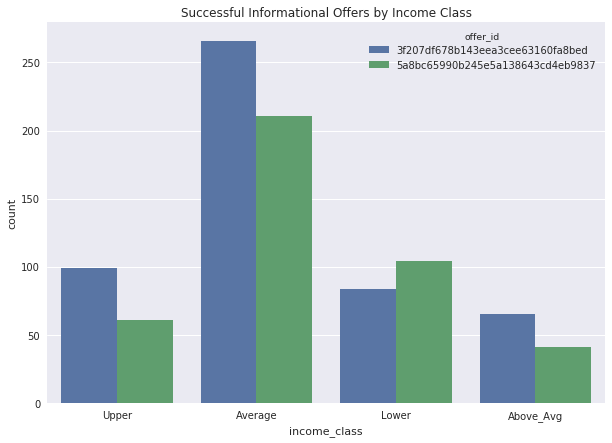

In [250]:
ax = sns.countplot(x="income_class", hue="offer_id", 
                 data=merged_success_info);
ax.set_title('Successful Informational Offers by Income Class');

As for income classes, they are most successful towards those that have an average income.

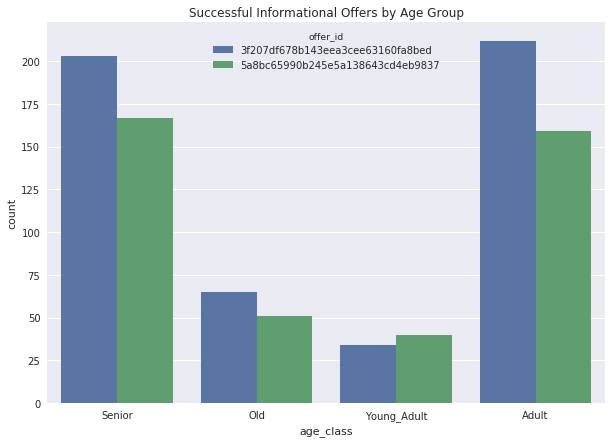

In [252]:
ax = sns.countplot(x="age_class", hue="offer_id", 
                 data=merged_success_info);
ax.set_title('Successful Informational Offers by Age Group');

And for age groups, they are most successful with Seniors and Adults.

#### Discount Success Groups

In [255]:
merged_success_discount = merged_success[merged_success['discount'] == 1]

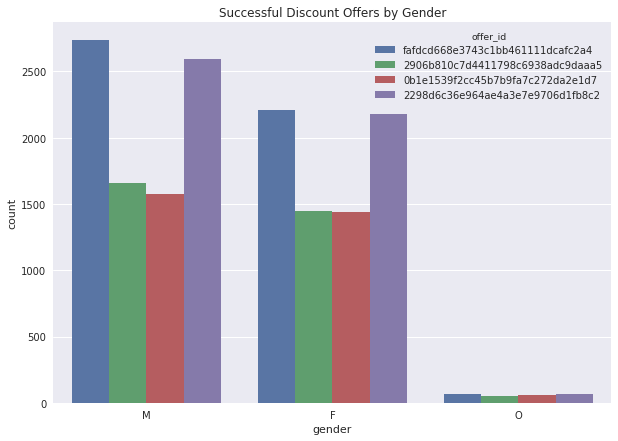

In [256]:
ax = sns.countplot(x="gender", hue="offer_id", 
                 data=merged_success_discount);
ax.set_title('Successful Discount Offers by Gender');

For discounts, the purple and blue offers are most successful for these 3 genders.

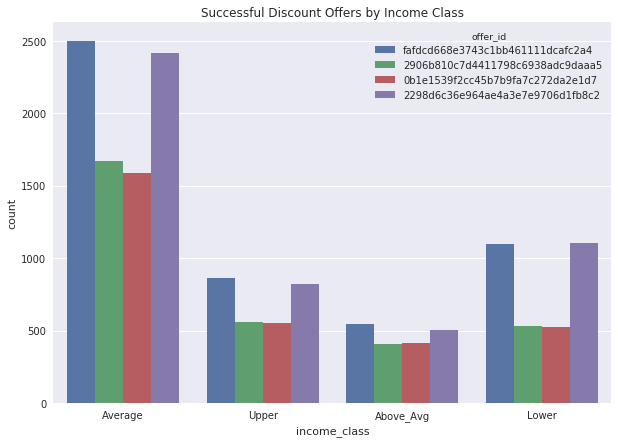

In [257]:
ax = sns.countplot(x="income_class", hue="offer_id", 
                 data=merged_success_discount);
ax.set_title('Successful Discount Offers by Income Class');

We see again the blue and purple offers dominating, but this time in all 4 income classes.

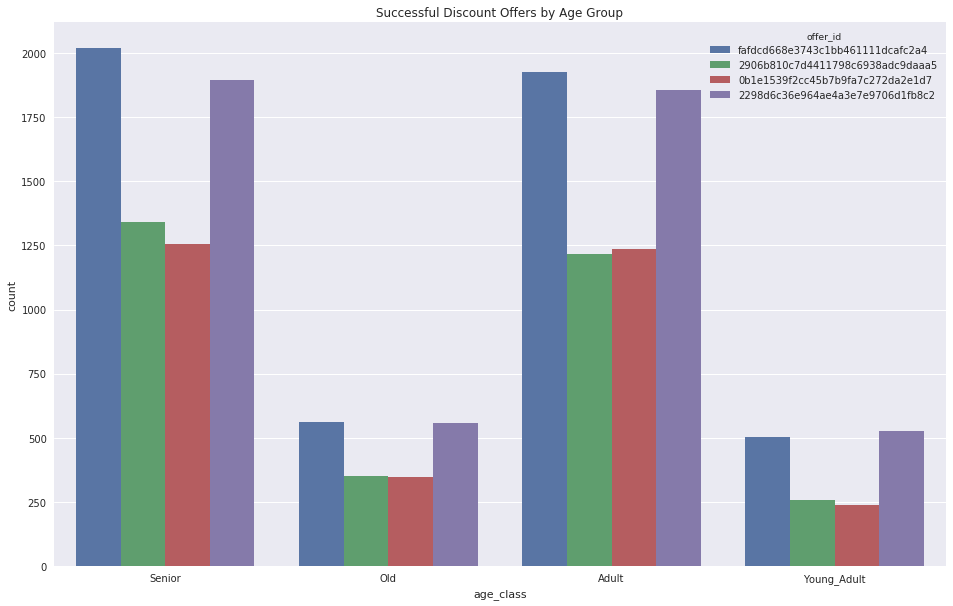

In [258]:
sns.set(rc={"figure.figsize":(16, 10)})
ax = sns.countplot(x="age_class", hue="offer_id", 
                 data=merged_success_discount);
ax.set_title('Successful Discount Offers by Age Group');

The same can be said for the 4 age classes.

## Making Our Model

For our model, we want to be able to predict whether or not a customer will successfully complete an offer or not. Since the output is either a 1 or 0, this is a classification problem that we would like to solve.

We will start with Logistic Regression, and then move onto Random Forest.

We will first select our features and our target variable, then split our data into training and testing.

But first, let's make gender numerical.

In [9]:
gender = {'M': 0,'F': 1, 'O':2}
merged_data.gender = [gender[item] for item in merged_data.gender]

In [10]:
merged_data.head()

,age_class,became_member_on,bogo,discount,duration,email,gender,id,income,income_class,...,member_month,member_year,member_year_month,mobile,offer_id,offer_successful,reward,social,time,web
0,Senior,2017-05-09,1,0,7,1,1,78afa995795e4d85b5d9ceeca43f5fef,100000.0,Upper,...,5,2017,2017-05,1,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,5,0,0.0,1
1,Senior,2017-05-09,0,0,3,1,1,78afa995795e4d85b5d9ceeca43f5fef,100000.0,Upper,...,5,2017,2017-05,1,5a8bc65990b245e5a138643cd4eb9837,0,0,1,7.0,0
2,Senior,2017-05-09,1,0,7,1,1,78afa995795e4d85b5d9ceeca43f5fef,100000.0,Upper,...,5,2017,2017-05,1,ae264e3637204a6fb9bb56bc8210ddfd,1,10,1,17.0,0
3,Senior,2017-05-09,1,0,5,1,1,78afa995795e4d85b5d9ceeca43f5fef,100000.0,Upper,...,5,2017,2017-05,1,f19421c1d4aa40978ebb69ca19b0e20d,1,5,1,21.0,1
4,Senior,2018-04-26,0,1,7,1,0,e2127556f4f64592b11af22de27a7932,70000.0,Average,...,4,2018,2018-04,1,2906b810c7d4411798c6938adc9daaa5,0,2,0,0.0,1


Some features we would like to exclude from our model include id (customer id), became_member_on (we have this column separated as year and month columns).

Source: https://towardsdatascience.com/feature-selection-techniques-in-machine-learning-with-python-f24e7da3f36e

https://www.quora.com/In-developing-a-machine-learning-model-can-I-use-the-ID-as-an-input-variable-or-how-can-I-benefit-from-the-fact-that-there-is-data-about-that-specific-individual?share=1

In [16]:
X = merged_data.drop(['offer_successful', 'id', 'offer_id',
                      'became_member_on', 'member_year_month',
                      'age_class', 'income_class'], axis=1)
y = merged_data['offer_successful']

#Split into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.20)

In [5]:
X_train.dtypes

bogo               int64
discount           int64
duration           int64
email              int64
gender             int64
income           float64
informational      int64
member_month       int64
member_year        int64
mobile             int64
reward             int64
social             int64
time             float64
web                int64
dtype: object

Now, we shall standardize then normalize our training and testing data.

But first let's see how our logistic regression model performs before and after normalizing.

### Logistic Regression

In [33]:
#Standardizing
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.fit_transform(X_test)

In [34]:
log_reg = LogisticRegression()
log_reg.fit(X_train_s, y_train)
y_pred = log_reg.predict(X_test_s)

In [35]:
print(classification_report(y_test, y_pred))
print('F1 Score:', f1_score(y_test, y_pred))
print('Precision Score:', precision_score(y_test, y_pred))
print('Recall Score:', recall_score(y_test, y_pred))
print('Accuracy Score:', accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.69      0.72      7028
           1       0.68      0.74      0.71      6273

    accuracy                           0.71     13301
   macro avg       0.71      0.71      0.71     13301
weighted avg       0.71      0.71      0.71     13301

F1 Score: 0.7072574484339191
Precision Score: 0.6790376998679771
Recall Score: 0.7379244380679101
Accuracy Score: 0.7119013607999398


Now lets normalize the data and check our model's performance once again.

In [36]:
#Normalize with MinMaxScaler
scaler = MinMaxScaler()
X_train_n = scaler.fit_transform(X_train_s)
X_test_n = scaler.fit_transform(X_test_s)

In [37]:
log_reg = LogisticRegression()
log_reg.fit(X_train_n, y_train)
y_pred = log_reg.predict(X_test_n)

In [38]:
print(classification_report(y_test, y_pred))
print('F1 Score:', f1_score(y_test, y_pred))
print('Precision Score:', precision_score(y_test, y_pred))
print('Recall Score:', recall_score(y_test, y_pred))
print('Accuracy Score:', accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.69      0.72      7028
           1       0.68      0.73      0.71      6273

    accuracy                           0.71     13301
   macro avg       0.71      0.71      0.71     13301
weighted avg       0.71      0.71      0.71     13301

F1 Score: 0.7056389825314128
Precision Score: 0.6793037321138811
Recall Score: 0.7340985174557628
Accuracy Score: 0.7111495376287498


We see a slightly better performance of the model after nornamalization for the F1 Score, Recall, and Accuracy.

### Tuning the Logistic Regression Model

In [39]:
#Sources: https://vitalflux.com/grid-search-explained-python-sklearn-examples/#Grid_Search_and_Logistic_Regression
#https://towardsdatascience.com/logistic-regression-model-tuning-with-scikit-learn-part-1-425142e01af5
#https://towardsdatascience.com/grid-search-for-model-tuning-3319b259367e
#https://towardsdatascience.com/regularization-in-machine-learning-76441ddcf99a

In [40]:
#C is the inverse of regularization strength.
#The smaller values of C, the stronger the regularization
# Regularization "discourages learning a more complex or flexible model, so as to avoid the risk of overfitting."

tuned_params = {'C': [0.1, 0.5, 1, 5, 10, 50, 100]}
clf = GridSearchCV(LogisticRegression(solver='liblinear'), tuned_params, cv=10, scoring="accuracy", refit=True, n_jobs=1)
clf.fit(X_train_n, y_train)

GridSearchCV(cv=10, estimator=LogisticRegression(solver='liblinear'), n_jobs=1,
             param_grid={'C': [0.1, 0.5, 1, 5, 10, 50, 100]},
             scoring='accuracy')

In [41]:
print(clf.best_score_)

0.7113345864661655


In [42]:
print(clf.best_params_)

{'C': 0.1}


In [43]:
clfLR = clf.best_estimator_
print('Test accuracy: %.3f' % clfLR.score(X_test_n, y_test))

Test accuracy: 0.711


In [44]:
print(classification_report(y_test, y_pred))
print('F1 Score:', f1_score(y_test, y_pred))
print('Precision Score:', precision_score(y_test, y_pred))
print('Recall Score:', recall_score(y_test, y_pred))
print('Accuracy Score:', accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.69      0.72      7028
           1       0.68      0.73      0.71      6273

    accuracy                           0.71     13301
   macro avg       0.71      0.71      0.71     13301
weighted avg       0.71      0.71      0.71     13301

F1 Score: 0.7056389825314128
Precision Score: 0.6793037321138811
Recall Score: 0.7340985174557628
Accuracy Score: 0.7111495376287498


Now, let's perform k-fold cross validation to estimate the skill of our logistic regression model.

In [32]:
cv = KFold(n_splits=20, random_state=24, shuffle=True)
scores = cross_val_score(log_reg, X_train_n, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
print('Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

Accuracy: 0.711 (0.009)


In [33]:
cv = KFold(n_splits=20, random_state=24, shuffle=True)
scores = cross_val_score(log_reg, X_test_n, y_test, scoring='accuracy', cv=cv, n_jobs=-1)
print('Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

Accuracy: 0.714 (0.017)


In [34]:
scores = cross_val_score(log_reg, X_train_n, y_train, cv=10)
print('Cross-Validation Accuracy Scores', scores)

Cross-Validation Accuracy Scores [ 0.71076865  0.69906015  0.71691729  0.71146617  0.71428571  0.70996241
  0.71221805  0.71804511  0.71015038  0.70765181]


In [35]:
scores = pd.Series(scores)
print('Min Score:', scores.min())
print('Average Score:', scores.mean())
print('Max Score', scores.max())

#source: https://medium.com/@lily_su/logistic-regression-accuracy-cross-validation-58d9eb58d6e6

Min Score: 0.699060150376
Average Score: 0.711052572992
Max Score 0.718045112782


And there we have it. We see that our model has a mean accuracy score of 71%.

Let's now use a Random Forest Classifier.

### Random Forest Classifier

In [23]:
clf=RandomForestClassifier(n_estimators=100)

In [24]:
clf.fit(X_train_n,y_train)

y_pred=clf.predict(X_test_n)

In [25]:
print(classification_report(y_test, y_pred))
print('F1 Score:', f1_score(y_test, y_pred))
print('Precision Score:', precision_score(y_test, y_pred))
print('Recall Score:', recall_score(y_test, y_pred))
print('Accuracy Score:', accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.72      0.71      0.71      7028
           1       0.68      0.69      0.68      6273

    accuracy                           0.70     13301
   macro avg       0.70      0.70      0.70     13301
weighted avg       0.70      0.70      0.70     13301

F1 Score: 0.6837227722772277
Precision Score: 0.679471032745592
Recall Score: 0.6880280567511557
Accuracy Score: 0.6997970077437786


In [34]:
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.695812344936


In [40]:
scores = cross_val_score(clf, X_train_n, y_train, cv=10)
print('Scores =', scores)

Scores = [ 0.70625822  0.69642857  0.71090226  0.70263158  0.7         0.70601504
  0.70075188  0.70526316  0.69943609  0.69486746]


In [41]:
scores = cross_val_score(clf, X_test_n, y_test, cv=10)
print('Scores =', scores)

Scores = [ 0.6904583   0.70473328  0.70398197  0.70398197  0.70773854  0.68947368
  0.71933785  0.70654628  0.70278405  0.7185854 ]


In [42]:
scores = pd.Series(scores)
print('Min Score:', scores.min())
print('Average Score:', scores.mean())
print('Max Score', scores.max())

Min Score: 0.689473684211
Average Score: 0.704762132294
Max Score 0.719337848006


### Tuning the Random Forest Classifier

In [27]:
pipe = Pipeline([('classifier' , RandomForestClassifier())])

param_grid = [
    
    {'classifier' : [RandomForestClassifier()],
    'classifier__n_estimators' : list(range(10,101,20)),
    'classifier__max_features' : list(range(6,14,2))} #14 features in X
]

clf = GridSearchCV(pipe, param_grid = param_grid, cv = 3, verbose=True, n_jobs=-1)

best_clf = clf.fit(X_train_n, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


In [28]:
print(best_clf.best_score_)

print(best_clf.best_params_)

best_clfRF = best_clf.best_estimator_
print('Test accuracy: %.3f' % best_clfRF.score(X_test_n, y_test))

0.7073872199582624
{'classifier': RandomForestClassifier(max_features=12, n_estimators=50), 'classifier__max_features': 12, 'classifier__n_estimators': 50}
Test accuracy: 0.707


In [29]:
scores = cross_val_score(best_clfRF, X_train_n, y_train, cv=10)
print('Scores =', scores)

Scores = [0.71033835 0.7174812  0.69191729 0.70169173 0.7174812  0.70018797
 0.69962406 0.70488722 0.71015038 0.71522556]


In [30]:
scores = cross_val_score(best_clfRF, X_test_n, y_test, cv=10)
print('Scores =', scores)

Scores = [0.69571751 0.70977444 0.71278195 0.7037594  0.70075188 0.7075188
 0.71654135 0.71654135 0.69774436 0.69172932]


In [31]:
scores = pd.Series(scores)
print('Min Score:', scores.min())
print('Average Score:', scores.mean())
print('Max Score', scores.max())

Min Score: 0.6917293233082706
Average Score: 0.7052860362777719
Max Score 0.7165413533834587


In [32]:
print(classification_report(y_test, y_pred))
print('F1 Score:', f1_score(y_test, y_pred))
print('Precision Score:', precision_score(y_test, y_pred))
print('Recall Score:', recall_score(y_test, y_pred))
print('Accuracy Score:', accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.72      0.71      0.71      7028
           1       0.68      0.69      0.68      6273

    accuracy                           0.70     13301
   macro avg       0.70      0.70      0.70     13301
weighted avg       0.70      0.70      0.70     13301

F1 Score: 0.6837227722772277
Precision Score: 0.679471032745592
Recall Score: 0.6880280567511557
Accuracy Score: 0.6997970077437786


We can see that for the F1 Score, Recall, and Accuracy, the Logistic Regression model beats out the Random Forest Classifier. However, for both models, the Precision score is very very close.